In [ ]:
import numpy as np

m = 0.149
l = 0.118
g = 9.8
Ix = 0.0001925
Iy = 0.0001662
Iz = 0.00035
kyaw = 1e-3 / m

x0, y0, z0 = 0.0, 0.0, 1.0
phi0, theta0, psi0 = 0.0, 0.0, 0.0
xdot0, ydot0, zdot0 = 0.0, 0.0, 0.0
phidot0, thetadot0, psidot0 = 0.0, 0.0, 0.0


def T1(t):      # Front left
    return m * g / 4


def T2(t):      # Front right
    return m * g / 4


def T3(t):      # Back right
    return m * g / 4


def T4(t):      # Back left
    return m * g / 4

dt = 0.01
time_end = 120
time_steps = int(time_end / dt)
t_values = np.linspace(0, time_end, time_steps)

x_vals = np.zeros(time_steps)
y_vals = np.zeros(time_steps)
z_vals = np.zeros(time_steps)
phi_vals = np.zeros(time_steps)
theta_vals = np.zeros(time_steps)
psi_vals = np.zeros(time_steps)
speed_vals = np.zeros(time_steps)

x, y, z = x0, y0, z0
phi, theta, psi = phi0, theta0, psi0
xdot, ydot, zdot = xdot0, ydot0, zdot0
phidot, thetadot, psidot = phidot0, thetadot0, psidot0

def derivatives(x, y, z, xdot, ydot, zdot,
                phi, theta, psi, phidot, thetadot, psidot, t):

    T1_val = T1(t)
    T2_val = T2(t)
    T3_val = T3(t)
    T4_val = T4(t)
    T = T1_val + T2_val + T3_val + T4_val

    xddot = T / m * (np.sin(phi) * np.sin(psi)
            + np.cos(phi) * np.sin(theta) * np.cos(psi))

    yddot = T / m * (np.sin(phi) * np.cos(psi)
            - np.cos(phi) * np.sin(theta) * np.cos(psi))

    zddot = T / m * np.cos(phi) * np.cos(theta) - g

    phiddot = (l / np.sqrt(2) * (T1_val + T4_val - (T2_val + T3_val))
               - (Iy - Iz) * thetadot * psidot) / Ix

    thetaddot = (l / np.sqrt(2) * (T1_val + T2_val - (T3_val + T4_val))
                 - (Iz - Ix) * phidot * psidot) / Iy

    psiddot = (kyaw * (T1_val + T3_val - T2_val - T4_val)
               - (Ix - Iy) * phidot * thetadot) / Iz

    return np.array([xdot, ydot, zdot, xddot, yddot, zddot,
                     phidot, thetadot, psidot, phiddot, thetaddot, psiddot])

def rk4_step(state, dt, t):
    k1 = derivatives(*state, t)
    k2 = derivatives(*(state + 0.5 * dt * k1), t + 0.5 * dt)
    k3 = derivatives(*(state + 0.5 * dt * k2), t + 0.5 * dt)
    k4 = derivatives(*(state + dt * k3), t + dt)
    new_state = state + (dt / 6) * (k1 + 2 * k2 + 2 * k3 + k4)

    if new_state[2] < 0: # Ground check
        new_state[2] = 0
        new_state[5] = 0

    new_state[6] = new_state[6] % (2 * np.pi)
    new_state[7] = new_state[7] % (2 * np.pi)
    new_state[8] = new_state[8] % (2 * np.pi)

    return new_state

state = np.array([x, y, z, xdot, ydot, zdot,
                  phi, theta, psi, phidot, thetadot, psidot])

for i in range(time_steps):

    # Set vals to current state
    x_vals[i], y_vals[i], z_vals[i] = state[0], state[1], state[2]
    phi_vals[i], theta_vals[i], psi_vals[i] = state[6], state[7], state[8]
    speed_vals[i] = np.sqrt(state[3]**2 + state[4]**2 + state[5]**2)

    # Update state
    state = rk4_step(state, dt, t_values[i])

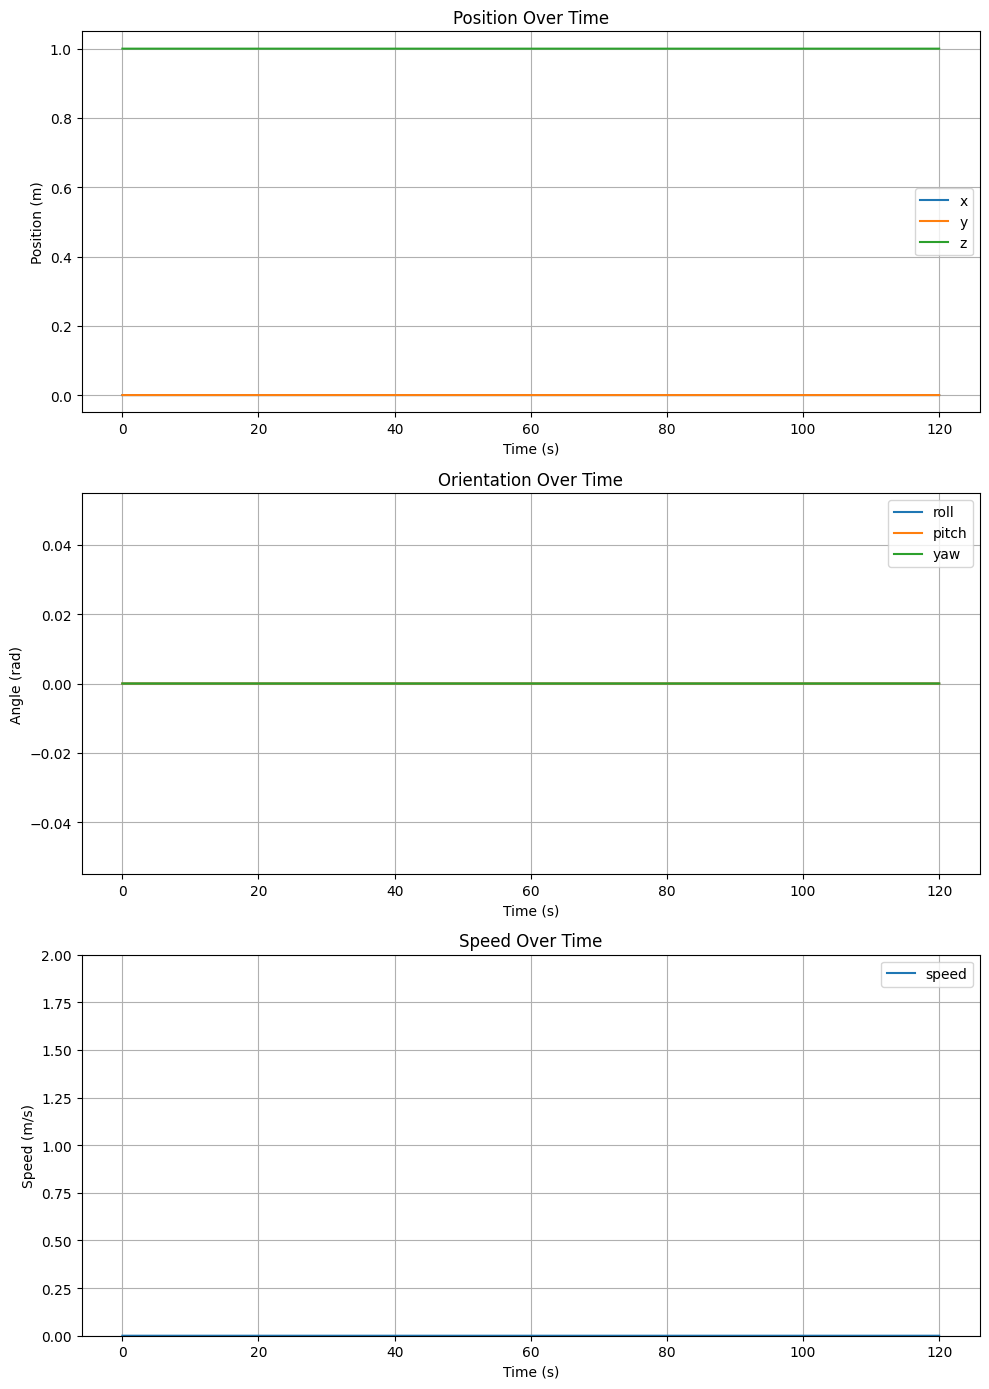

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(10, 14))

axs[0].plot(t_values, x_vals, label='x')
axs[0].plot(t_values, y_vals, label='y')
axs[0].plot(t_values, z_vals, label='z')

axs[0].set_title('Position Over Time')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Position (m)')
axs[0].legend()
axs[0].grid()

axs[1].plot(t_values, phi_vals, label='roll')
axs[1].plot(t_values, theta_vals, label='pitch')
axs[1].plot(t_values, psi_vals, label='yaw')
axs[1].set_title('Orientation Over Time')
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Angle (rad)')
axs[1].legend()
axs[1].grid()

axs[2].plot(t_values, speed_vals, label='speed')
axs[2].set_title('Speed Over Time')
axs[2].set_xlabel('Time (s)')
axs[2].set_ylabel('Speed (m/s)')
axs[2].set_ylim([0,2])
axs[2].legend()
axs[2].grid()

plt.tight_layout()
plt.show()

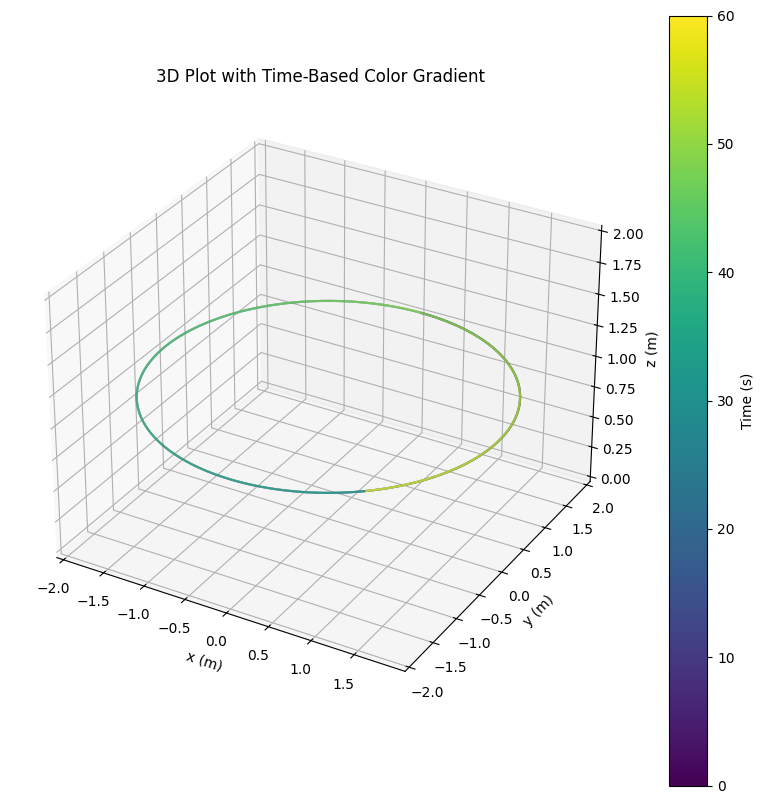

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.colors import Normalize

# Create segments for the line with changing colors
points = np.array([x_vals, y_vals, z_vals]).T.reshape(-1, 1, 3)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a color map based on time values
norm = Normalize(vmin=min(t_values), vmax=max(t_values))
cmap = plt.cm.viridis  # Choose your color map

# Create the 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Add the color-mapped line
lc = Line3DCollection(segments, cmap=cmap, norm=norm)
lc.set_array(t_values)  # Provide the time values directly for mapping
ax.add_collection(lc)

# Set axis limits to match data ranges
ax.set_xlim([min(x_vals), max(x_vals)])
ax.set_ylim([min(y_vals), max(y_vals)])
ax.set_zlim([0, 2])

# Set labels and title
ax.set_title('3D Plot with Time-Based Color Gradient')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
ax.set_zlabel('z (m)')

# Add color bar to show the time scale
cbar = fig.colorbar(lc, ax=ax, orientation='vertical', label='Time (s)')

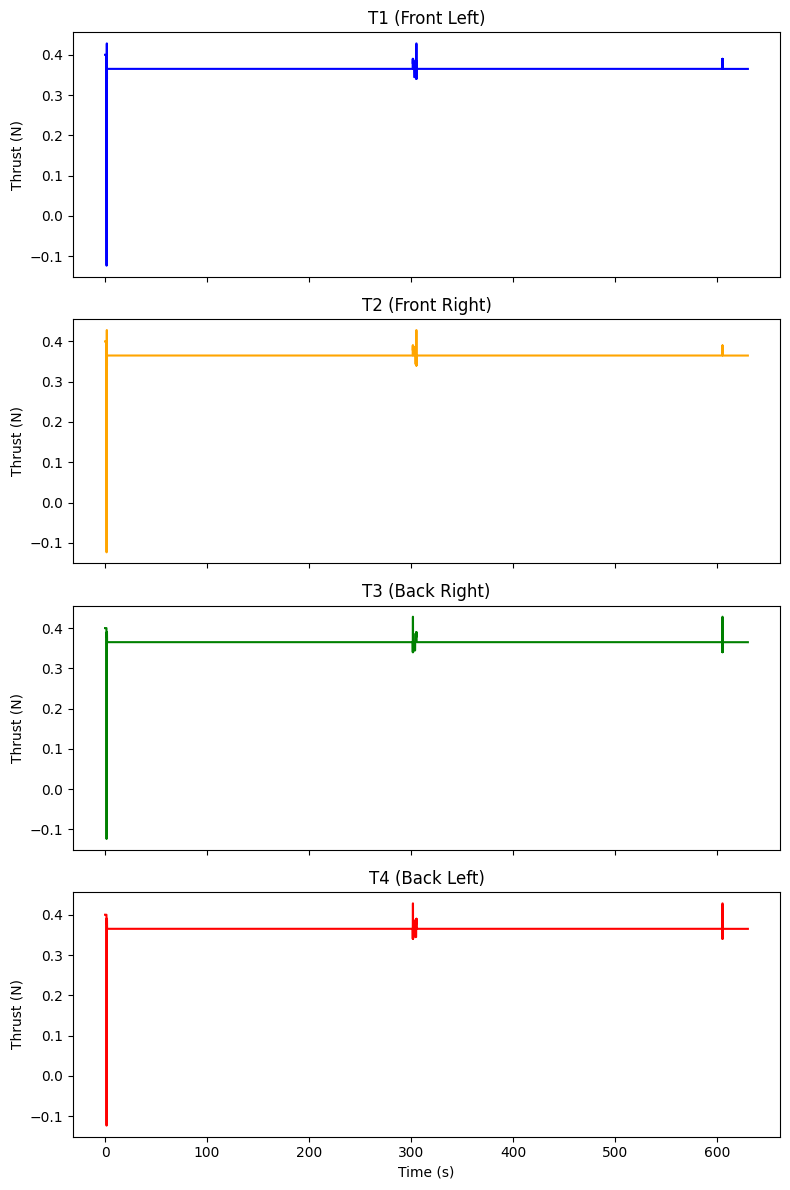

In [ ]:
def T1(t):      # Front left
    # Ascend
    if t < 1.4:
      T1 = 0.4
    elif t < 1.5:
      T1 = -0.12373

    # Fly forward
    elif t < 1.6:
      T1 = 0.34005
    elif t < 1.7:
      T1 = 0.4282
    elif t < 1.8:
      T1 = 0.4282
    elif t < 1.9:
      T1 = 0.34005
    elif t < 301.5:
      T1 = m * g / 4
    elif t < 301.6:
      T1 = 0.39005
    elif t < 301.7:
      T1 = 0.3782
    elif t < 301.8:
      T1 = 0.3782
    elif t < 301.9:
      T1 = 0.39005

    # Rest
    elif t < 302.9:
      T1 = m * g / 4

    # Turn left
    elif t < 303.9:
      T1 = 0.34457
    elif t < 304.9:
      T1 = 0.38553

    # Fly forward
    elif t < 305:
      T1 = 0.34005
    elif t < 305.1:
      T1 = 0.4282
    elif t < 305.2:
      T1 = 0.4282
    elif t < 305.3:
      T1 = 0.34005
    elif t < 604.9:
      T1 = m * g / 4
    elif t < 605:
      T1 = 0.39005
    elif t < 605.1:
      T1 = 0.3782
    elif t < 605.2:
      T1 = 0.3782
    elif t < 605.3:
      T1 = 0.39005

    # Descend
    else: T1 = m * g / 4.001

    return T1

def T2(t):      # Front right
    if t < 1.4:
      T2 = 0.4
    elif t < 1.5:
      T2 = -0.12373

    elif t < 1.6:
      T2 = 0.34005
    elif t < 1.7:
      T2 = 0.4282
    elif t < 1.8:
      T2 = 0.4282
    elif t < 1.9:
      T2 = 0.34005
    elif t < 301.5:
      T2 = m * g / 4
    elif t < 301.6:
      T2 = 0.39005
    elif t < 301.7:
      T2 = 0.3782
    elif t < 301.8:
      T2 = 0.3782
    elif t < 301.9:
      T2 = 0.39005

    elif t < 302.9:
      T2 = m * g / 4

    elif t < 303.9:
      T2 = 0.38553
    elif t < 304.9:
      T2 = 0.34457

    elif t < 305:
      T2 = 0.34005
    elif t < 305.1:
      T2 = 0.4282
    elif t < 305.2:
      T2 = 0.4282
    elif t < 305.3:
      T2 = 0.34005
    elif t < 604.9:
      T2 = m * g / 4
    elif t < 605:
      T2 = 0.39005
    elif t < 605.1:
      T2 = 0.3782
    elif t < 605.2:
      T2 = 0.3782
    elif t < 605.3:
      T2 = 0.39005

    else: T2 = m * g / 4.001

    return T2

def T3(t):      # Back right
    if t < 1.4:
      T3 = 0.4
    elif t < 1.5:
      T3 = -0.12373

    elif t < 1.6:
      T3 = 0.39005
    elif t < 1.7:
      T3 = 0.3782
    elif t < 1.8:
      T3 = 0.3782
    elif t < 1.9:
      T3 = 0.39005
    elif t < 301.5:
      T3 = m * g / 4
    elif t < 301.6:
      T3 = 0.34005
    elif t < 301.7:
      T3 = 0.4282
    elif t < 301.8:
      T3 = 0.4282
    elif t < 301.9:
      T3 = 0.34005

    elif t < 302.9:
      T3 = m * g / 4

    elif t < 303.9:
      T3 = 0.34457
    elif t < 304.9:
      T3 = 0.38553

    elif t < 305:
      T3 = 0.39005
    elif t < 305.1:
      T3 = 0.3782
    elif t < 305.2:
      T3 = 0.3782
    elif t < 305.3:
      T3 = 0.39005
    elif t < 604.9:
      T3 = m * g / 4
    elif t < 605:
      T3 = 0.34005
    elif t < 605.1:
      T3 = 0.4282
    elif t < 605.2:
      T3 = 0.4282
    elif t < 605.3:
      T3 = 0.34005

    else: T3 = m * g / 4.001

    return T3

def T4(t):      # Back left
    if t < 1.4:
      T4 = 0.4        # Lift up
    elif t < 1.5:
      T4 = -0.12373   # Stop lift

    elif t < 1.6:
      T4 = 0.39005    # Tilt forward
    elif t < 1.7:
      T4 = 0.3782     # Stop tilt
    elif t < 1.8:
      T4 = 0.3782     # Tilt backward
    elif t < 1.9:
      T4 = 0.39005    # Stop tilt
    elif t < 301.5:
      T4 = m * g / 4  # Fly straight
    elif t < 301.6:
      T4 = 0.34005    # Tilt backward
    elif t < 301.7:
      T4 = 0.4282     # Stop tilt
    elif t < 301.8:
      T4 = 0.4282     # Tilt forward
    elif t < 301.9:
      T4 = 0.34005    # Stop tilt

    elif t < 302.9:
      T4 = m * g / 4  # Rest

    elif t < 303.9:
      T4 = 0.38553    # Yaw left
    elif t < 304.9:
      T4 = 0.34457    # Stop yaw

    elif t < 305:
      T4 = 0.39005    # Tilt forward
    elif t < 305.1:
      T4 = 0.3782     # Stop tilt
    elif t < 305.2:
      T4 = 0.3782     # Tilt backward
    elif t < 305.3:
      T4 = 0.39005    # Stop tilt
    elif t < 604.9:
      T4 = m * g / 4  # Fly straight
    elif t < 605:
      T4 = 0.34005    # Tilt backward
    elif t < 605.1:
      T4 = 0.4282     # Stop tilt
    elif t < 605.2:
      T4 = 0.4282     # Tilt forward
    elif t < 605.3:
      T4 = 0.34005    # Stop tilt

    else: T4 = m * g / 4.001  # Descend

    return T4

# Time array
t = np.linspace(0, 630, int(630 / dt))

# Thrust values (constant for this example)
T1_vals = np.zeros_like(t)
T2_vals = np.zeros_like(t)
T3_vals = np.zeros_like(t)
T4_vals = np.zeros_like(t)

for i, time in enumerate(t):
    T1_vals[i] = T1(time)
    T2_vals[i] = T2(time)
    T3_vals[i] = T3(time)
    T4_vals[i] = T4(time)

# Plotting
fig, axs = plt.subplots(4, 1, figsize=(8, 12), sharex=True)

axs[0].plot(t, T1_vals, color='blue')
axs[0].set_title("T1 (Front Left)")
axs[0].set_ylabel("Thrust (N)")

axs[1].plot(t, T2_vals, color='orange')
axs[1].set_title("T2 (Front Right)")
axs[1].set_ylabel("Thrust (N)")

axs[2].plot(t, T3_vals, color='green')
axs[2].set_title("T3 (Back Right)")
axs[2].set_ylabel("Thrust (N)")

axs[3].plot(t, T4_vals, color='red')
axs[3].set_title("T4 (Back Left)")
axs[3].set_xlabel("Time (s)")
axs[3].set_ylabel("Thrust (N)")

# General adjustments
plt.tight_layout()
plt.show()